In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import bambi as bmb
import arviz as az
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Problemen:
- Geen volledige paden in repo (veiligheidsrisicio)
- Encoding dataset naar UTF8 omzetten (encoding problemen?)

In [2]:
df = pd.read_csv("../Materials/KVO_META.csv", encoding='utf8')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.sample(5)

,Image,Collection,Production,Date,Occasion,Multiple bill,Performances_ID,Normalised title,Original language,Composer,World-premiere,Original title,Genre,Directors
3757,1930-1931_00121-20220209_151648.jpg,1930-1931,Driemeisjeshuis,1930-09-30,NaN,False,922561,Driemeisjeshuis,DUI,Heinrich Berté,1916,Das Dreimäderlhaus,leichte oper,Fé Derickx & Bernard Tokkie
2032,1919-1920_00083-20220207_102809.jpg,1919-1920,Baas Gansendonck,1920-01-01,NaN,False,762659,Baas Gansendonck,NL,Jos De Klerk,1919,Baas Gansendonck,?,Henry Fontaine
4375,1933-1934_00139-20220210_143424.jpg,1933-1934,Madame Butterfly,1933-12-25,NaN,False,299332,Madame Butterfly,ITA,Giacomo Puccini,1904,Madama Butterfly,opera seria,Flor Bosmans
1616,1911-1912 Vlaamse Opera_00105-20211216_161700.jpg,1911-1912,Zigeunerliefde,1911-12-25,NaN,True,945136,Zigeunerliefde,DUI,Franz Lehar,1910,Zigeunerliebe,operette,Henry Fontaine
188,K.V.O. programmas 1893-97_00406-20211201_13055...,1893-1897,Fidelio,1896-10-03,Gala-vertoning,False,297497,Fidelio,DUI,Ludwig van Beethoven,1805,Fidelio,rettungsoper,Edward Keurvels & Henry Fontaine


In [3]:
data = []

for work, group in df.groupby('Normalised title'):
    group = group.groupby('Collection').sample(1) # consider one performance per season?
    group = group.sort_values('Date').iloc[0:2] # get very first performace and first reperformance
    if len(group) > 1:
        time_diff = group.iloc[1]['Date'].year - group.iloc[0]['Date'].year
        meta = list(group.iloc[0][['Normalised title', 'Directors', 'Composer', 'Original language', 'Genre', 'Date']].values)
        data.append(meta + [time_diff])

data = pd.DataFrame(data, columns=['titel', 'directie', 'componist', 'taal', 'genre', 'datum', 'diff'])
data = data[~data['diff'].isna()]
data

,titel,directie,componist,taal,genre,datum,diff
0,Carmen,Fé Derickx & Bernard Tokkie,Georges Bizet,FR,opéra comique,1928-04-29,4.0
1,Christ'l,Henry Fontaine,Georg Jarno,?,leichte oper,1911-02-19,0.0
2,Czaar en Timmerman,Jef Judels & Bernard Tokkie,Albert Lortzing,DUI,zangspel,1904-03-26,4.0
3,Dansenreeks,Fé Derickx & Bernard Tokkie,?,?,Ballet,1924-01-12,1.0
4,Dansenreeks,Fé Derickx & Bernard Tokkie,?,?,Ballet,1924-04-05,5.0
...,...,...,...,...,...,...,...
143,Tristan en Isolde,Henry Fontaine,Richard Wagner,DUI,gesamtkunstwerk,1910-12-16,14.0
144,Weenerbloed,Fé Derickx & Bernard Tokkie,Johann Strauss,DUI,operette,1930-03-30,1.0
145,Winternachtsdroom,Jef Judels & Bernard Tokkie,August de Boeck,NL,lyrisch drama,1903-12-25,3.0
146,Winternachtsdroom,Jef Judels & Bernard Tokkie,August De Boeck,NL,Lyrisch Drama,1902-12-23,5.0


In [4]:
data.dtypes

titel                object
directie             object
componist            object
taal                 object
genre                object
datum        datetime64[ns]
diff                float64
dtype: object

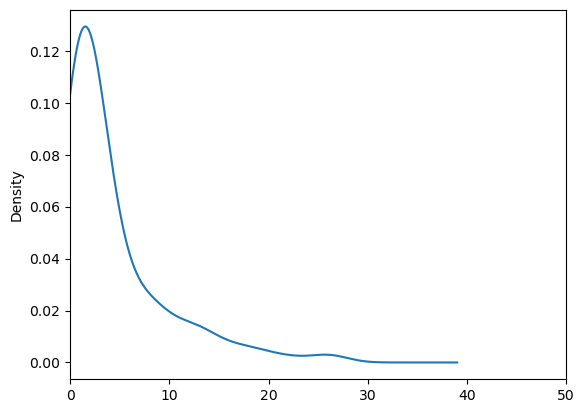

In [5]:
data['diff'].plot.kde()
plt.xlim((0, 50));

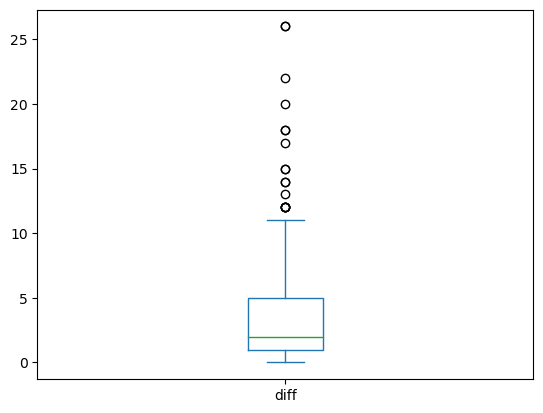

In [6]:
data['diff'].plot.box();

In [7]:
data['diff'].describe()

count    147.000000
mean       4.204082
std        5.257661
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       26.000000
Name: diff, dtype: float64

In [8]:
import numpy as np
data['diff'] = data['diff'].astype(np.int32)

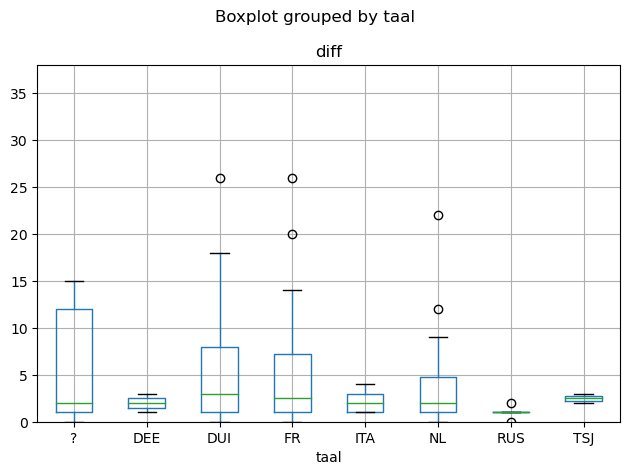

In [9]:
data.boxplot('diff', 'taal')
plt.ylim(0, 38)
plt.tight_layout();

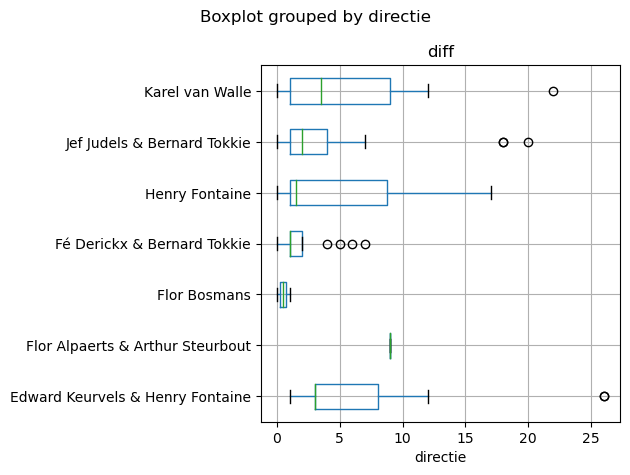

In [10]:
data.boxplot('diff', 'directie', vert=False)
plt.tight_layout();

In [11]:
print(len(data))
data = data[~data.isna()]
print(len(data))

147
147


In [12]:
data = data[['taal', 'diff', 'directie', 'componist']]
data['taal'].fillna('<UNK>', inplace=True)
data['taal'] = data['taal'].str.replace('?', '<UNK>', regex=False)
data.sample(10)

,taal,diff,directie,componist
133,NL,0,Karel van Walle,Emile Wambach
6,DUI,12,Karel van Walle,Carl Milläcker
7,NL,2,Jef Judels & Bernard Tokkie,Jan Blockx
83,<UNK>,1,Fé Derickx & Bernard Tokkie,Igor Stravinsky
14,DUI,17,Henry Fontaine,Richard Wagner
132,NL,2,Jef Judels & Bernard Tokkie,Paul Gilson
127,ITA,1,Jef Judels & Bernard Tokkie,Ruggiero Leoncavallo
90,DUI,3,Edward Keurvels & Henry Fontaine,Ludwig van Beethoven
37,NL,3,Jef Judels & Bernard Tokkie,August De Boeck
22,DUI,10,Karel van Walle,Ignaz Brüll


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, taal]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 194 seconds.


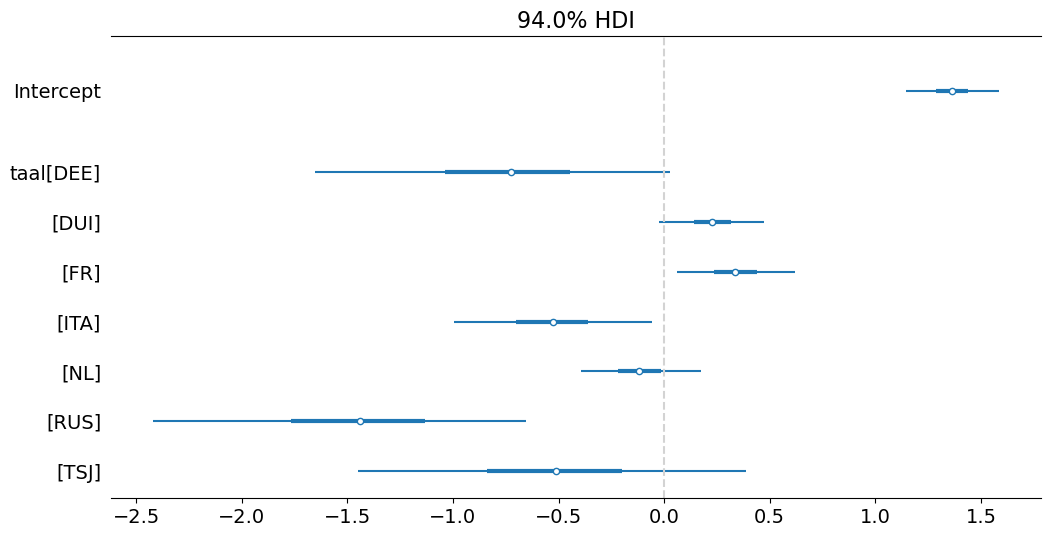

In [13]:
model = bmb.Model('diff ~ taal', data, family='poisson')
fit = model.fit(draws=1000, chains=4)
az.summary(fit)
az.plot_forest(fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, taal, directie]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.


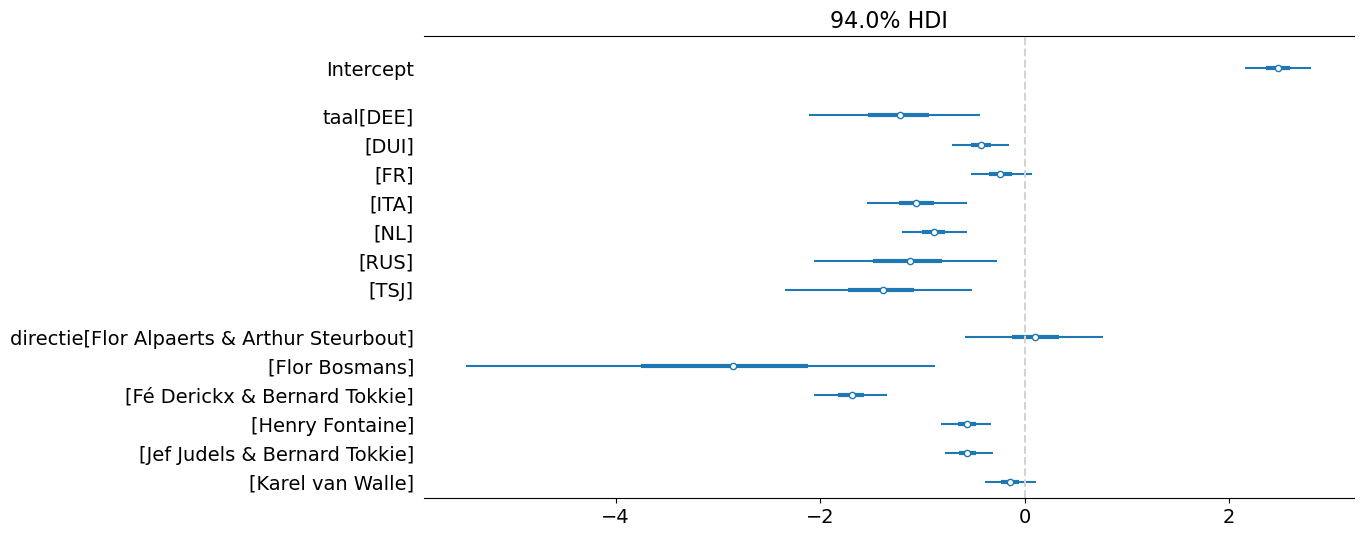

In [14]:
model = bmb.Model('diff ~ taal + directie', data, family='poisson')
fit = model.fit(draws=1000, chains=4)
az.summary(fit)
az.plot_forest(fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, componist]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7239 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 344 divergences after tuning. Increase `target_accept` or reparameterize.
c:\Users\monaa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


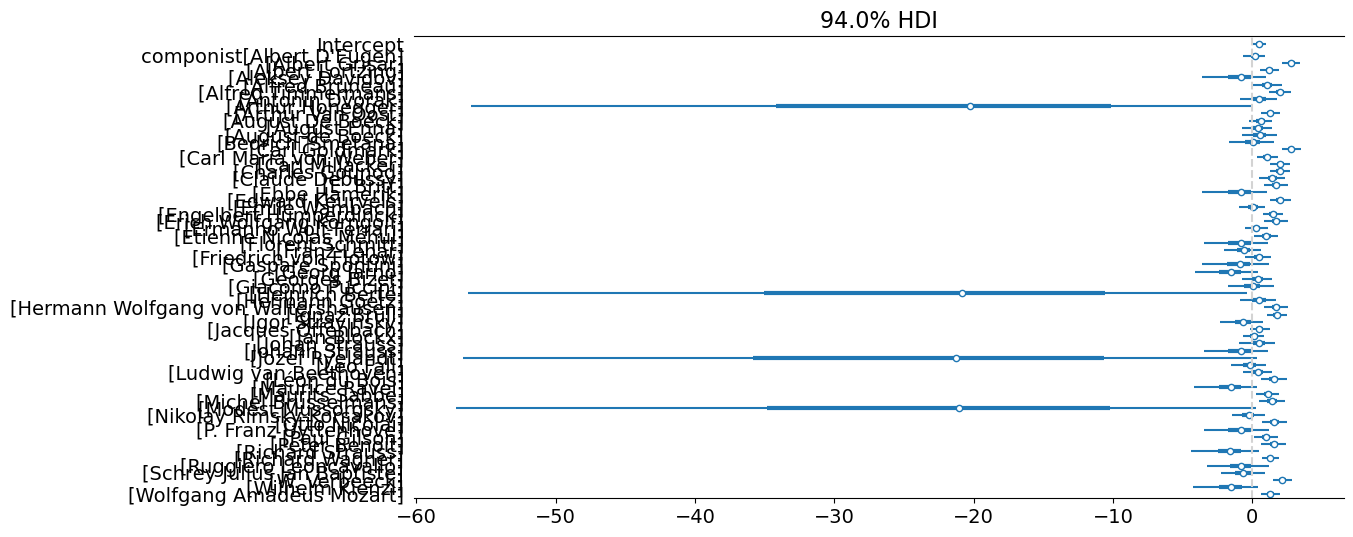

In [15]:
model = bmb.Model('diff ~ componist', data, family='poisson')
fit = model.fit(draws=1000, chains=4)
az.summary(fit)
az.plot_forest(fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');